# 掩盖softmax层

In [1]:
import tensorflow as tf


def sequence_mask(x, valid_lens, value):
    mask = tf.range(start=0, limit=x.shape[1], dtype=tf.float32)[None, :] < tf.cast(valid_lens, dtype=tf.float32)[:, None]
    if len(x.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), x, value)
    else:
        return tf.where(mask, x, value)
    print(x)
   

def mask_softmax(x, valid_lens):
    # x[valid_len: ] = -1e6
    # softmax(x)
    x_shape = x.shape
    if valid_lens is None:
        return tf.nn.softmax(x, axis=-1)
    if len(valid_lens.shape) == 1:
        valid_lens = tf.repeat(valid_lens, repeats=x_shape[1])
    else:
        valid_lens = tf.reshape(valid_lens, shape=-1)
    x = tf.reshape(x, shape=(-1, x_shape[-1]))
    # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
    x = sequence_mask(x, valid_lens, -1e6)
    x = tf.reshape(x, x_shape)
    return tf.nn.softmax(x, axis=-1)


x = tf.reshape(tf.range(100, dtype=tf.float32), shape=(-1, 4, 5))
print(x)
valid_lens = tf.constant([
   3, 2, 1, 3, 0
])
mask_softmax(x, valid_lens)

Metal device set to: Apple M1 Pro
tf.Tensor(
[[[ 0.  1.  2.  3.  4.]
  [ 5.  6.  7.  8.  9.]
  [10. 11. 12. 13. 14.]
  [15. 16. 17. 18. 19.]]

 [[20. 21. 22. 23. 24.]
  [25. 26. 27. 28. 29.]
  [30. 31. 32. 33. 34.]
  [35. 36. 37. 38. 39.]]

 [[40. 41. 42. 43. 44.]
  [45. 46. 47. 48. 49.]
  [50. 51. 52. 53. 54.]
  [55. 56. 57. 58. 59.]]

 [[60. 61. 62. 63. 64.]
  [65. 66. 67. 68. 69.]
  [70. 71. 72. 73. 74.]
  [75. 76. 77. 78. 79.]]

 [[80. 81. 82. 83. 84.]
  [85. 86. 87. 88. 89.]
  [90. 91. 92. 93. 94.]
  [95. 96. 97. 98. 99.]]], shape=(5, 4, 5), dtype=float32)


2023-02-24 22:05:57.227454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 22:05:57.227478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(5, 4, 5), dtype=float32, numpy=
array([[[0.09003057, 0.24472848, 0.665241  , 0.        , 0.        ],
        [0.09003057, 0.24472848, 0.665241  , 0.        , 0.        ],
        [0.09003057, 0.24472848, 0.665241  , 0.        , 0.        ],
        [0.09003057, 0.24472848, 0.665241  , 0.        , 0.        ]],

       [[0.2689414 , 0.7310586 , 0.        , 0.        , 0.        ],
        [0.2689414 , 0.7310586 , 0.        , 0.        , 0.        ],
        [0.2689414 , 0.7310586 , 0.        , 0.        , 0.        ],
        [0.2689414 , 0.7310586 , 0.        , 0.        , 0.        ]],

       [[1.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.09003057, 0.24472848, 0.665241  , 0.        , 0.        ],
        [0.09003057, 0.24472848, 

# 加性注意力

In [40]:
from attention import AdditiveAttentionLayer

attention = AdditiveAttentionLayer(num_hidden=20, dropout=0.1)
queries = tf.random.normal(shape=(2, 3, 20))
keys = tf.random.normal(shape=(2, 5, 7))
values = tf.random.normal(shape=(2, 5, 8))
valid_lens = tf.constant([
    2, 4
])

scores = attention(queries, keys, values, valid_lens)
print(scores)
print(attention.attention_weights)

tf.Tensor(
[[[-1.0442429e+00  4.6222693e-01  3.7916511e-01  9.6615148e-01
    2.2189447e-01 -8.8808823e-01 -7.3989734e-02  9.1667759e-01]
  [-1.0697777e+00  4.8217595e-01  3.5096878e-01  9.5816904e-01
    2.3972003e-01 -8.5897088e-01 -7.4246027e-02  9.7011662e-01]
  [-1.0476183e+00  4.6486390e-01  3.7543803e-01  9.6509635e-01
    2.2425075e-01 -8.8423938e-01 -7.4023619e-02  9.2374146e-01]]

 [[-3.5058373e-01  2.4638353e-01 -1.8569909e-01  8.9326613e-02
    7.0472521e-01 -4.0818244e-01  2.7468809e-01  1.8326432e-01]
  [-2.2051618e-01  2.3597541e-01 -8.0913305e-06  1.4171034e-01
    4.8823899e-01 -4.7554746e-01  5.2522027e-01  3.4304345e-01]
  [-3.5547799e-01  2.0611273e-01  7.7304140e-02  2.7947500e-01
    5.2542472e-01 -4.6053749e-01  3.7951532e-01  2.9996064e-01]]], shape=(2, 3, 8), dtype=float32)
tf.Tensor(
[[[0.75249153 0.24750847 0.         0.         0.        ]
  [0.7728675  0.2271325  0.         0.         0.        ]
  [0.75518495 0.24481508 0.         0.         0.        ]]



In [41]:
queries, keys = tf.random.normal(shape=(2, 1, 20)), tf.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = tf.repeat(tf.reshape(
    tf.range(40, dtype=tf.float32), shape=(1, 10, 4)), repeats=2, axis=0)
valid_lens = tf.constant([2, 6])
attention = AdditiveAttentionLayer(num_hidden=20, dropout=0.1)

scores=attention(queries, keys, values, valid_lens, training=False)
print(scores)
print(attention.attention_weights)

tf.Tensor(
[[[ 2.  3.  4.  5.]]

 [[10. 11. 12. 13.]]], shape=(2, 1, 4), dtype=float32)
tf.Tensor(
[[[0.5        0.5        0.         0.         0.         0.
   0.         0.         0.         0.        ]]

 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
   0.         0.         0.         0.        ]]], shape=(2, 1, 10), dtype=float32)


# Bahdanau注意力

## 数据加载

In [1]:
from datasets import EnglishChineseTranslateDatasets, EnglishFrenchTranslateDatasets
from data_generator import TranslateDataGenerator
import tensorflow as tf

# ds = EnglishChineseTranslateDatasets()
ds = EnglishFrenchTranslateDatasets()
test_x, test_y = ds.load_test_data()
test_x, test_y = test_x[: 512], test_y[: 512]
gen = TranslateDataGenerator(
    test_x, test_y, x_sentence_len=5, y_sentence_len=5, min_freq=0
)

gen.summary()
enc_x, x_len, dec_x, y_len, target_y = gen[: 1]

building source vocab...
building targe vocab...
converting x to enc_x...
converting y to dec_x...
case count: 512
source: 
  vocab size: 233
  enc_x avg len: 2.994140625
  enc_x max len: 4
targe: 
  vocab size: 497
  dec_x avg len: 4.14453125
  dec_x max len: 6


## 模型建立

In [29]:
from translate_model import AttentionSeq2SeqTranslateModel
import tensorflow as tf
import numpy as np

m = AttentionSeq2SeqTranslateModel(
    enc_vocab_size=len(gen.x_vocab), enc_embedding_size=256,
    dec_vocab_size=len(gen.y_vocab), dec_embedding_size=256,
    dropout=0.1, gru_layers=2, gru_hidden_units=256
)

## 模型训练

In [30]:
print(f"all cases: {len(gen)}")
lr_list=[8e-3, 5e-3, 3e-3, 1e-3]
for i, lr in enumerate(lr_list):
    epochs=25 * (i + 1)
    print(f"train {epochs} epochs for learning rate {lr}")
    m.custom_fit(
        gen,
        batch_size=128,
        epochs=epochs,
        learning_rate=lr
    )

all cases: 512
train 25 epochs for learning rate 0.008
Epoch 1/25
[=========================================================================] 100%
Epoch 1, Loss: 4.2390
Epoch 2/25
[=========================================================================] 100%
Epoch 2, Loss: 3.6877
Epoch 3/25
[=========================================================================] 100%
Epoch 3, Loss: 3.2126
Epoch 4/25
[=========================================================================] 100%
Epoch 4, Loss: 3.0942
Epoch 5/25
[=========================================================================] 100%
Epoch 5, Loss: 2.9473
Epoch 6/25
[=========================================================================] 100%
Epoch 6, Loss: 2.8063
Epoch 7/25
[=========================================================================] 100%
Epoch 7, Loss: 2.7523
Epoch 8/25
[=========================================================================] 100%
Epoch 8, Loss: 2.5902
Epoch 9/25
[=====================

[=========================================================================] 100%
Epoch 46, Loss: 0.0275
Epoch 47/50
[=========================================================================] 100%
Epoch 47, Loss: 0.0250
Epoch 48/50
[=========================================================================] 100%
Epoch 48, Loss: 0.0233
Epoch 49/50
[=========================================================================] 100%
Epoch 49, Loss: 0.0237
Epoch 50/50
[=========================================================================] 100%
Epoch 50, Loss: 0.0258
train 75 epochs for learning rate 0.003
Epoch 1/75
[=========================================================================] 100%
Epoch 1, Loss: 0.0327
Epoch 2/75
[=========================================================================] 100%
Epoch 2, Loss: 0.0447
Epoch 3/75
[=========================================================================] 100%
Epoch 3, Loss: 0.0627
Epoch 4/75
[======================================

[=========================================================================] 100%
Epoch 66, Loss: 0.0399
Epoch 67/75
[=========================================================================] 100%
Epoch 67, Loss: 0.0239
Epoch 68/75
[=========================================================================] 100%
Epoch 68, Loss: 0.0240
Epoch 69/75
[=========================================================================] 100%
Epoch 69, Loss: 0.0131
Epoch 70/75
[=========================================================================] 100%
Epoch 70, Loss: 0.0125
Epoch 71/75
[=========================================================================] 100%
Epoch 71, Loss: 0.0145
Epoch 72/75
[=========================================================================] 100%
Epoch 72, Loss: 0.0289
Epoch 73/75
[=========================================================================] 100%
Epoch 73, Loss: 0.0152
Epoch 74/75
[=======================================================================

[=========================================================================] 100%
Epoch 61, Loss: 0.0008
Epoch 62/100
[=========================================================================] 100%
Epoch 62, Loss: 0.0007
Epoch 63/100
[=========================================================================] 100%
Epoch 63, Loss: 0.0007
Epoch 64/100
[=========================================================================] 100%
Epoch 64, Loss: 0.0006
Epoch 65/100
[=========================================================================] 100%
Epoch 65, Loss: 0.0006
Epoch 66/100
[=========================================================================] 100%
Epoch 66, Loss: 0.0006
Epoch 67/100
[=========================================================================] 100%
Epoch 67, Loss: 0.0005
Epoch 68/100
[=========================================================================] 100%
Epoch 68, Loss: 0.0005
Epoch 69/100
[===============================================================

## 翻译测试

In [34]:
idx = 100
sub_enc_x, sub_enc_valid_len, sub_dec_x, sub_target_valid_len, sub_target_y = gen[idx: idx + 1]
print(gen.x[idx], sub_enc_valid_len[0])
print(gen.x_vocab.to_tokens(list(sub_enc_x[0])))
print(gen.y[idx], sub_target_valid_len[0])
print(gen.y_vocab.to_tokens(list(sub_dec_x[0])))
print(gen.y_vocab.to_tokens(list(sub_target_y[0])))

y_pred, attentions = m.translate(sub_enc_x, sub_enc_valid_len, dec_vocab=gen.y_vocab, max_len=gen.y_sentence_len)
print(y_pred)

come in . 3
['come', 'in', '.', '<pad>', '<pad>']
entrez ! 3
['<bos>', 'entrez', '!', '<pad>', '<pad>']
['entrez', '!', '<eos>', '<pad>', '<pad>']
entrez !


## 注意力显示

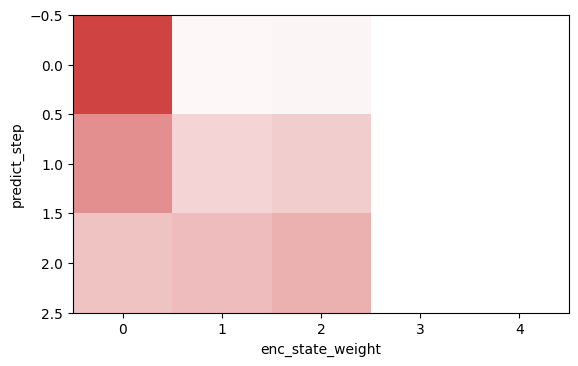

In [35]:
from attention import plot_attention_map
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plot_attention_map(np.squeeze(np.array(attentions), axis=(1, 2, 3)))
plt.ylabel("predict_step")
plt.xlabel("enc_state_weight")
plt.show()

In [36]:
from translate_model import bleu_acc

for i in range(40, 60):
    sub_enc_x, sub_enc_valid_len, sub_dec_x, sub_target_valid_len, sub_target_y = gen[i: i + 1]
    y_pred, _ = m.translate(sub_enc_x, sub_enc_valid_len, dec_vocab=gen.y_vocab, max_len=gen.y_sentence_len)
    x = gen.x_vocab.to_tokens(list(sub_enc_x[0]))[: sub_enc_valid_len[0]]
    y_pred = y_pred.split()
    label = gen.y_vocab.to_tokens(list(sub_target_y[0]))[: sub_target_valid_len[0] - 1]
    print(x, " -> ", label)
    print(y_pred)
    print(" BLEU: ", bleu_acc(label, y_pred, 3))

['hop', 'in', '.']  ->  ['monte', '.']
['monte', '.']
 BLEU:  1.0
['hop', 'in', '.']  ->  ['montez', '.']
['monte', '.']
 BLEU:  0.7071067811865476
['hug', 'me', '.']  ->  ['serre-moi', 'dans', 'tes', 'bras', '!']
['serre-moi', 'dans', 'tes', 'bras', '!']
 BLEU:  1.0
['hug', 'me', '.']  ->  ['serrez-moi', 'dans', 'vos', 'bras', '!']
['serre-moi', 'dans', 'tes', 'bras', '!']
 BLEU:  0.0
['i', 'fell', '.']  ->  ['je', 'suis', 'tombée', '.']
['je', 'suis', 'resté', '.']
 BLEU:  0.0
['i', 'fell', '.']  ->  ['je', 'suis', 'tombé', '.']
['je', 'suis', 'resté', '.']
 BLEU:  0.0
['i', 'know', '.']  ->  ['je', 'sais', '.']
['je', 'sais', '.']
 BLEU:  1.0
['i', 'left', '.']  ->  ['je', 'suis', 'parti', '.']
['je', 'suis', 'partie', '.']
 BLEU:  0.0
['i', 'left', '.']  ->  ['je', 'suis', 'partie', '.']
['je', 'suis', 'partie', '.']
 BLEU:  1.0
['i', 'lost', '.']  ->  ["j'ai", 'perdu', '.']
['je', 'me', 'suis', 'reposé', '.']
 BLEU:  0.0
['i', 'paid', '.']  ->  ['j’ai', 'payé', '.']
['j’ai', 'payé